In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests
import os
import numpy as np
from math import floor
import seaborn as sn

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 200)

#### Helper functions

In [2]:
def confusion_matrix(df: pd.DataFrame, col1: str, col2: str):
    """
    Given a dataframe with at least
    two categorical columns, create a 
    confusion matrix of the count of the columns
    cross-counts
    
    use like:
    
    >>> confusion_matrix(test_df, 'actual_label', 'predicted_label')
    """
    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )

## Load Statistics

In [3]:
matches_df = pd.read_csv('../data/outputs/matches.csv')
matches_df.head(2)

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,away_home,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,Milan,Udinese,4,False,True,6,2,home,Win,True,...,NaN,9,12,8,39,39,36,3,Udinese,1
1,Sampdoria,Atalanta,0,True,False,2,2,home,Loss,False,...,NaN,14,6,9,48,47,34,13,Atalanta,0


In [4]:
standings_df = pd.read_csv('../data/outputs/standings.csv')
standings_df.head(2)

,position,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group,competition
0,1,30,NaN,24,3,3,75,66,21,45,Napoli,0,Serie A
1,2,30,NaN,18,7,5,61,49,20,29,Lazio,0,Serie A


In [5]:
no_goal_group_hist = pd.read_csv('../data/outputs/simulate_historical/no_goal_group.csv')
no_goal_group_hist['next_giornata'] = no_goal_group_hist['curr_giornata'] + 1
no_goal_group_hist.tail(2)

,n_matches,main_team,team_group,competition,no_goal,no_goal_streak_weighted,goal_streak_weighted,tot_giornata,no_goal_streak_weighted_ratio,goal_streak_weighted_ratio,no_goal_ratio,goal_ratio,curr_giornata,next_giornata
9267,10,Wolves,2,Premier League,5,59.0,98.0,157.0,0.375796,0.624204,0.5,0.5,31,32
9268,30,Wolves,all,Premier League,18,252.0,214.0,466.0,0.540773,0.459227,0.6,0.4,31,32


#### Rebuild matches to use later

In [31]:
hh = matches_df.rename(columns={'goal_fatti':'home_team_goal',
                          'goal_subiti':'away_team_goal',
                          'team_group':'away_team_group'})\
                [['main_team','opponent_team','away_home', 'competition',
                  'no_goal','home_team_goal','away_team_goal',
                  'giornata','away_team_group']]
aa = matches_df.rename(columns={'team_group':'home_team_group'})\
                    [['main_team','opponent_team',
                      'away_home','home_team_group']]
tt_matches_df = hh.merge(aa,\
                 left_on=['main_team','opponent_team'],\
                 right_on=['opponent_team','main_team'])
ttt_matches_df = tt_matches_df[(tt_matches_df.away_home_x=='home')&(tt_matches_df.away_home_y=='away')]
tttt_matches_df = ttt_matches_df.rename(columns={
                                'main_team_x':'home_team',
                                'opponent_team_x':'away_team',
                                'away_home_x': 'away_home'})\
                .drop(columns=['away_home_y','main_team_y','opponent_team_y'], errors='ignore')
tttt_matches_df[['away_team_group','home_team_group']] = tttt_matches_df[['away_team_group','home_team_group']].astype(str)
matches = tttt_matches_df
matches.head()

,home_team,away_team,away_home,competition,no_goal,home_team_goal,away_team_goal,giornata,away_team_group,home_team_group
1,Milan,Udinese,home,Serie A,False,4,2,1.0,1,0
5,Sampdoria,Atalanta,home,Serie A,True,0,2,1.0,0,2
9,Lecce,Inter,home,Serie A,False,1,2,1.0,0,2
12,Monza,Torino,home,Serie A,False,1,2,1.0,1,1
14,Fiorentina,Cremonese,home,Serie A,False,3,2,1.0,2,1


In [32]:
ngg = no_goal_group_hist[['n_matches', 'main_team', 'team_group', 'competition',
       'no_goal_streak_weighted_ratio', 'goal_streak_weighted_ratio',
       'no_goal_ratio', 'goal_ratio', 'next_giornata']]

dd = matches.merge(ngg,
                    left_on=['home_team','away_team_group','giornata'],
                    right_on=['main_team','team_group','next_giornata'])\
            .merge(ngg,
                    left_on=['away_team','home_team_group','giornata'],
                    right_on=['main_team','team_group','next_giornata'])

In [33]:
dd['no_goal_streak_weighted_ratio'] = \
        dd['no_goal_streak_weighted_ratio_x'] + dd['no_goal_streak_weighted_ratio_y']
dd['no_goal_ratio'] = \
        dd['no_goal_ratio_x'] + dd['no_goal_ratio_y']
dd['competition'] = dd['competition_x']
dd = dd[['home_team', 'away_team', 'competition', 'away_home', 'giornata',
        'no_goal', 'home_team_goal', 'away_team_goal',
       'no_goal_streak_weighted_ratio_x',
       'no_goal_ratio_x',
       'no_goal_streak_weighted_ratio_y',
       'no_goal_ratio_y', 'goal_ratio_y',
       'no_goal_streak_weighted_ratio', 'no_goal_ratio']]
dd['no_goal_from_simple_ratio'] = dd.no_goal_ratio > 1.44
dd['no_goal_from_streak_ratio'] = dd.no_goal_streak_weighted_ratio > 1.5
dd['no_goal_from_simple_ratio_correct'] = dd['no_goal_from_simple_ratio'] == dd['no_goal']
dd['no_goal_from_streak_ratio_correct'] = dd['no_goal_from_streak_ratio'] == dd['no_goal']
dd[['home_team', 'away_team', 'away_home', 'competition', 'giornata','no_goal',
   'no_goal_from_simple_ratio_correct','no_goal_from_streak_ratio_correct','no_goal_from_streak_ratio']].head()

,home_team,away_team,away_home,competition,giornata,no_goal,no_goal_from_simple_ratio_correct,no_goal_from_streak_ratio_correct,no_goal_from_streak_ratio
0,Milan,Bologna,home,Serie A,3.0,True,False,False,False
1,Spezia,Sassuolo,home,Serie A,3.0,False,False,False,True
2,Verona,Atalanta,home,Serie A,3.0,True,False,False,False
3,Lecce,Empoli,home,Serie A,3.0,False,False,False,True
4,Sassuolo,Milan,home,Serie A,4.0,True,True,True,True


In [39]:
thresholds = []
competitions = []
correctness =[]
correctness_str =[]
n_guesses =[]
n_guesses_str =[]
after_x_matches =[]
i = 0
for after_x_match in [0, 10, 15, 20, 25]:
    for comp in ['Serie A','Bundesliga','Premier League','La Liga']:
        i = 0
        while i < 2:
            tt = dd[dd.competition==comp].copy()
            tt = tt[tt.giornata > after_x_match]
            tt['no_goal_from_simple_ratio'] = tt.no_goal_ratio > i
            tt['no_goal_from_streak_ratio'] = tt.no_goal_streak_weighted_ratio > i
            try:
                corr = tt[tt.no_goal_from_simple_ratio].no_goal.value_counts(normalize=True)[True]
                corr_str = tt[tt.no_goal_from_streak_ratio].no_goal.value_counts(normalize=True)[True]
            except Exception as e:
                corr = 0
                corr_str = 0
            after_x_matches.append(after_x_match)
            n_guesses.append(len(tt[tt.no_goal_from_simple_ratio]))
            n_guesses_str.append(len(tt[tt.no_goal_from_streak_ratio]))
            competitions.append(comp)
            correctness.append(corr)
            correctness_str.append(corr_str)
            thresholds.append(i)
            i = i + 0.1

In [41]:
results = pd.DataFrame([thresholds,correctness, correctness_str, competitions, n_guesses, n_guesses_str, after_x_matches]).T
results.columns = ['threshold','corr_simple','corr_streak','competition','n_guesses','n_guesses_str','after_x_matches']
results

,threshold,corr_simple,corr_streak,competition,n_guesses,n_guesses_str,after_x_matches
0,0,0.520833,0.520833,Serie A,240,240,0
1,0.1,0.520833,0.520833,Serie A,240,240,0
2,0.2,0.520833,0.516807,Serie A,240,238,0
3,0.3,0.518828,0.519313,Serie A,239,233,0
4,0.4,0.512931,0.511111,Serie A,232,225,0
...,...,...,...,...,...,...,...
395,1.5,1.0,0.666667,La Liga,1,3,25
396,1.6,0,0,La Liga,1,1,25
397,1.7,0,0,La Liga,0,1,25
398,1.8,0,0,La Liga,0,1,25


In [46]:
results[(results.corr_simple > 0.6)&(results.corr_streak > 0.6)]

,threshold,corr_simple,corr_streak,competition,n_guesses,n_guesses_str,after_x_matches
38,1.8,0.75,0.75,Bundesliga,4,4,0
39,1.9,0.75,0.75,Bundesliga,4,4,0
115,1.5,0.75,0.833333,Bundesliga,4,6,10
116,1.6,1.0,0.666667,Bundesliga,3,3,10
159,1.9,0.666667,0.666667,La Liga,3,3,10
231,1.1,0.604167,0.611111,La Liga,48,54,15
249,0.9,0.627119,0.625,Serie A,59,56,20
250,1.0,0.625,0.608696,Serie A,40,46,20
294,1.4,0.666667,0.888889,Premier League,6,9,20
372,1.2,0.636364,0.642857,Premier League,11,14,25


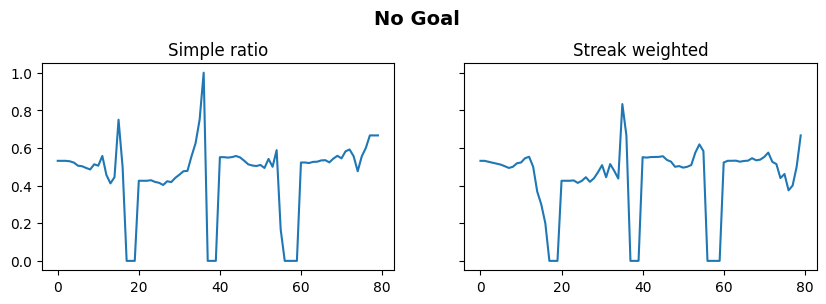

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"No Goal", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

results.corr_simple.plot(kind='line', title='Simple ratio', ax=axes[0])
results.corr_streak.plot(kind='line', title='Streak weighted', ax=axes[1])
plt.show()

In [177]:
dd.no_goal_streak_weighted_ratio.quantile(0.9)

1.4577336641852772

In [178]:
dd.no_goal_ratio.quantile(0.9)

1.3333333333333333

<Axes: ylabel='Frequency'>

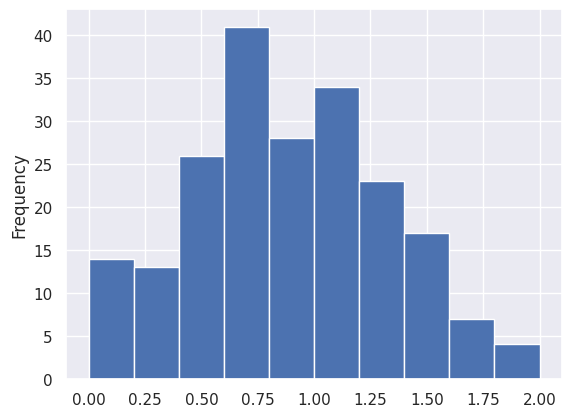

In [179]:
dd.no_goal_streak_weighted_ratio.plot(kind='hist')

<Axes: ylabel='Frequency'>

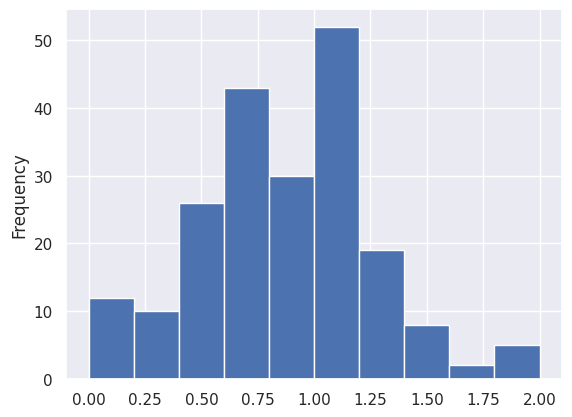

In [180]:
dd.no_goal_ratio.plot(kind='hist')

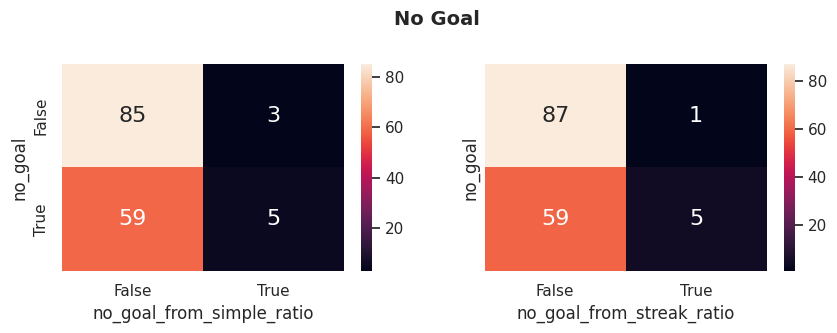

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"No Goal", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

sn.set(font_scale=1) # for label size
sn.heatmap(confusion_matrix(dd, 'no_goal','no_goal_from_simple_ratio'), annot=True, annot_kws={"size": 16}, ax=axes[0]) # font size
sn.heatmap(confusion_matrix(dd, 'no_goal','no_goal_from_streak_ratio'), annot=True, annot_kws={"size": 16}, ax=axes[1]) # font size
plt.show()

### Next Matches

In [524]:
next_matches = pd.DataFrame([\
    ["Bundesliga","RB Leipzig","Augsburg"],
    ["Bundesliga","Schalke 04","Hertha"],
    ["Bundesliga","FC Koln","Mainz"],
    ["Bundesliga","Stuttgart","Dortmund"],
    ["Bundesliga","Bayern Munich","Hoffenheim"],
    ["Bundesliga","Ein Frankfurt","M'gladbach"],
    ["Bundesliga","Werder Bremen","Freiburg"],
    ["Bundesliga","Union Berlin","Bochum"],
    ["Bundesliga","Wolfsburg","Leverkusen"],
    ["La Liga","Vallecano","Osasuna"],
    ["La Liga","Villarreal","Valladolid"],
    ["La Liga","Ath Bilbao","Sociedad"],
    ["La Liga","Betis","Espanol"],
    ["La Liga","Cadiz","Real Madrid"],
    ["La Liga","Girona","Elche"],
    ["La Liga","Getafe","Barcelona"],
    ["La Liga","Valencia","Sevilla"],
    ["La Liga","Ath Madrid","Almeria"],
    ["La Liga","Celta","Mallorca"],
    ["Premier League","Aston Villa","Newcastle"],
    ["Premier League","Chelsea","Brighton"],
    ["Premier League","Everton","Fulham"],
    ["Premier League","Southampton","Crystal Palace"],
    ["Premier League","Tottenham","Bournemouth"],
    ["Premier League","Wolves","Brentford"],
    ["Premier League","Man City","Leicester"],
    ["Premier League","West Ham","Arsenal"],
    ["Premier League","Nott'm Forest","Man United"],
    ["Premier League","Leeds","Liverpool"]],\
    columns=['competition','home_team','away_team'])

#### Check names are spelled correctly

In [525]:
dd = next_matches.merge(standings_df, left_on='home_team', right_on='team_short_name', how='left')
assert len(dd[dd.position.isna()]['home_team'])==0, dd[dd.position.isna()]['home_team']

In [526]:
dd = next_matches.merge(standings_df, left_on='away_team', right_on='team_short_name', how='left')
assert len(dd[dd.position.isna()]['away_team']) == 0, dd[dd.position.isna()]['away_team']

#### Assign team groups

In [527]:
next_matches_with_group = next_matches.merge(standings_df[['competition','team_short_name','team_group']],\
                   left_on=['competition','home_team'],\
                   right_on=['competition','team_short_name'], how='left')\
            .merge(standings_df[['competition','team_short_name','team_group']],\
                   left_on=['competition','away_team'],\
                   right_on=['competition','team_short_name'], how='left', suffixes=['_home','_away'])\
            [['competition','home_team','away_team','team_group_home','team_group_away']]
next_matches_with_group['team_group_home'] = next_matches_with_group['team_group_home'].astype(str)
next_matches_with_group['team_group_away'] = next_matches_with_group['team_group_away'].astype(str)

### NoGoal/Goal Overall

In [528]:
nggall = no_goal_group[no_goal_group.team_group=='all']

In [529]:
nggall.columns

Index(['main_team', 'team_group', 'competition', 'n_matches', 'no_goal',
       'no_goal_streak_weighted', 'goal_streak_weighted', 'tot_giornata',
       'no_goal_streak_weighted_ratio', 'goal_streak_weighted_ratio',
       'no_goal_ratio', 'goal_ratio'],
      dtype='object')

In [530]:
dd1 = next_matches.merge(nggall, left_on=['competition','home_team'], right_on=['competition','main_team'])
dd1 = dd1.merge(nggall, left_on=['competition','away_team'], right_on=['competition','main_team'], suffixes=['_home','_away'])
dd1['no_goal_streak_weighted_ratio'] = dd1['no_goal_streak_weighted_ratio_home'] * dd1['no_goal_streak_weighted_ratio_away']
dd1['goal_streak_weighted_ratio'] = dd1['goal_streak_weighted_ratio_home'] * dd1['goal_streak_weighted_ratio_away']
dd1['no_goal_ratio'] = dd1['no_goal_ratio_home'] * dd1['no_goal_ratio_away']

#### NoGoal

In [531]:
dd1[['competition','home_team','away_team',\
    'no_goal_ratio_home','no_goal_ratio_away',\
    'no_goal_ratio']].sort_values('no_goal_ratio', ascending=False).head(10)

,competition,home_team,away_team,no_goal_ratio_home,no_goal_ratio_away,no_goal_ratio
15,La Liga,Getafe,Barcelona,0.535714,0.785714,0.420918
10,La Liga,Villarreal,Valladolid,0.642857,0.642857,0.413265
11,La Liga,Ath Bilbao,Sociedad,0.607143,0.571429,0.346939
27,Premier League,Nott'm Forest,Man United,0.566667,0.551724,0.312644
18,La Liga,Celta,Mallorca,0.464286,0.642857,0.298469
9,La Liga,Vallecano,Osasuna,0.464286,0.607143,0.281888
23,Premier League,Tottenham,Bournemouth,0.433333,0.633333,0.274444
26,Premier League,West Ham,Arsenal,0.620690,0.433333,0.268966
7,Bundesliga,Union Berlin,Bochum,0.481481,0.555556,0.267490
24,Premier League,Wolves,Brentford,0.600000,0.433333,0.260000


#### NoGoal Streak Weighted

In [532]:
dd1[['competition','home_team','away_team',\
    'no_goal_streak_weighted_ratio_home','no_goal_streak_weighted_ratio_away',\
    'no_goal_streak_weighted_ratio']].sort_values('no_goal_streak_weighted_ratio', ascending=False).head(10)

,competition,home_team,away_team,no_goal_streak_weighted_ratio_home,no_goal_streak_weighted_ratio_away,no_goal_streak_weighted_ratio
15,La Liga,Getafe,Barcelona,0.542169,0.791866,0.429325
11,La Liga,Ath Bilbao,Sociedad,0.561446,0.643373,0.361219
27,Premier League,Nott'm Forest,Man United,0.523605,0.655251,0.343093
10,La Liga,Villarreal,Valladolid,0.546988,0.597590,0.326875
21,Premier League,Everton,Fulham,0.592275,0.529680,0.313716
13,La Liga,Cadiz,Real Madrid,0.614458,0.496386,0.305008
18,La Liga,Celta,Mallorca,0.462651,0.653012,0.302116
9,La Liga,Vallecano,Osasuna,0.460241,0.638554,0.293889
7,Bundesliga,Union Berlin,Bochum,0.502646,0.584656,0.293875
22,Premier League,Southampton,Crystal Palace,0.545064,0.519313,0.283059


#### Goal Streak Weighted

In [533]:
dd1[['competition','home_team','away_team',\
    'goal_streak_weighted_ratio_home','goal_streak_weighted_ratio_away',\
    'goal_streak_weighted_ratio']].sort_values('goal_streak_weighted_ratio', ascending=False).head(10)

,competition,home_team,away_team,goal_streak_weighted_ratio_home,goal_streak_weighted_ratio_away,goal_streak_weighted_ratio
4,Bundesliga,Bayern Munich,Hoffenheim,0.669312,0.648148,0.433813
3,Bundesliga,Stuttgart,Dortmund,0.648148,0.653439,0.423525
6,Bundesliga,Werder Bremen,Freiburg,0.666667,0.592593,0.395062
12,La Liga,Betis,Espanol,0.471292,0.807229,0.380440
0,Bundesliga,RB Leipzig,Augsburg,0.513228,0.690476,0.354371
5,Bundesliga,Ein Frankfurt,M'gladbach,0.658730,0.526455,0.346792
14,La Liga,Girona,Elche,0.665060,0.491566,0.326921
17,La Liga,Ath Madrid,Almeria,0.445783,0.674699,0.300769
25,Premier League,Man City,Leicester,0.621005,0.448498,0.278519
8,Bundesliga,Wolfsburg,Leverkusen,0.447090,0.616402,0.275587


### NoGoal/Goal Group

In [534]:
dd2 = next_matches_with_group.merge(no_goal_group,\
                    left_on=['competition','home_team','team_group_away'],
                    right_on=['competition','main_team','team_group']).drop(columns=['team_group'])\
                        .merge(no_goal_group,\
                    left_on=['competition','away_team','team_group_home'],
                    right_on=['competition','main_team','team_group'], suffixes=['_home','_away'])
dd2['no_goal_streak_weighted_ratio'] = dd2['no_goal_streak_weighted_ratio_home'] * dd2['no_goal_streak_weighted_ratio_away']
dd2['goal_streak_weighted_ratio'] = dd2['goal_streak_weighted_ratio_home'] * dd2['goal_streak_weighted_ratio_away']
dd2['no_goal_ratio'] = dd2['no_goal_ratio_home'] * dd2['no_goal_ratio_away']

#### No Goal Home/Away

In [535]:
dd2[(dd2['n_matches_home'] > 6)&(dd2['n_matches_away']>6)]\
    [['competition','home_team','away_team',\
    'no_goal_ratio_home','no_goal_ratio_away',\
    'no_goal_ratio','n_matches_home','n_matches_away']]\
    .sort_values('no_goal_ratio', ascending=False).head(10)

,competition,home_team,away_team,no_goal_ratio_home,no_goal_ratio_away,no_goal_ratio,n_matches_home,n_matches_away
15,La Liga,Getafe,Barcelona,0.636364,0.900000,0.572727,11,10
10,La Liga,Villarreal,Valladolid,0.666667,0.818182,0.545455,9,11
27,Premier League,Nott'm Forest,Man United,0.636364,0.800000,0.509091,11,10
11,La Liga,Ath Bilbao,Sociedad,0.875000,0.571429,0.500000,8,7
7,Bundesliga,Union Berlin,Bochum,0.571429,0.818182,0.467532,7,11
18,La Liga,Celta,Mallorca,0.600000,0.777778,0.466667,10,9
13,La Liga,Cadiz,Real Madrid,0.727273,0.500000,0.363636,11,8
21,Premier League,Everton,Fulham,0.700000,0.500000,0.350000,10,8
20,Premier League,Chelsea,Brighton,0.666667,0.500000,0.333333,9,12
26,Premier League,West Ham,Arsenal,0.545455,0.555556,0.303030,11,9


#### NoGoal Streak Weighted

In [536]:
dd2[(dd2['n_matches_home'] > 6)&(dd2['n_matches_away']>6)]\
    [['competition','home_team','away_team',\
    'no_goal_streak_weighted_ratio_home','no_goal_streak_weighted_ratio_away',\
    'no_goal_streak_weighted_ratio','n_matches_home','n_matches_away']]\
    .sort_values('no_goal_streak_weighted_ratio', ascending=False).head(10)

,competition,home_team,away_team,no_goal_streak_weighted_ratio_home,no_goal_streak_weighted_ratio_away,no_goal_streak_weighted_ratio,n_matches_home,n_matches_away
11,La Liga,Ath Bilbao,Sociedad,0.870229,0.744444,0.647837,8,7
7,Bundesliga,Union Berlin,Bochum,0.822222,0.764331,0.628450,7,11
15,La Liga,Getafe,Barcelona,0.638554,0.911243,0.581878,11,10
18,La Liga,Celta,Mallorca,0.621469,0.773973,0.481000,10,9
10,La Liga,Villarreal,Valladolid,0.654135,0.704142,0.460604,9,11
27,Premier League,Nott'm Forest,Man United,0.485549,0.889571,0.431930,11,10
21,Premier League,Everton,Fulham,0.671141,0.639706,0.429333,10,8
20,Premier League,Chelsea,Brighton,0.798611,0.491979,0.392900,9,12
13,La Liga,Cadiz,Real Madrid,0.686667,0.564356,0.387525,11,8
9,La Liga,Vallecano,Osasuna,0.510638,0.662420,0.338257,9,10


#### Goal Streak Weighted

In [537]:
dd2[['competition','home_team','away_team',\
    'goal_streak_weighted_ratio_home','goal_streak_weighted_ratio_away',\
    'goal_streak_weighted_ratio','n_matches_home','n_matches_away']]\
    .sort_values('goal_streak_weighted_ratio', ascending=False).head(10)

,competition,home_team,away_team,goal_streak_weighted_ratio_home,goal_streak_weighted_ratio_away,goal_streak_weighted_ratio,n_matches_home,n_matches_away
1,Bundesliga,Schalke 04,Hertha,0.656716,1.000000,0.656716,5,3
4,Bundesliga,Bayern Munich,Hoffenheim,0.847328,0.644444,0.546056,10,10
14,La Liga,Girona,Elche,0.742690,0.657143,0.488053,11,10
8,Bundesliga,Wolfsburg,Leverkusen,0.523810,0.815603,0.427221,11,11
25,Premier League,Man City,Leicester,0.750000,0.511494,0.383621,8,12
5,Bundesliga,Ein Frankfurt,M'gladbach,0.638462,0.568345,0.362867,10,10
3,Bundesliga,Stuttgart,Dortmund,0.607362,0.562500,0.341641,12,6
28,Premier League,Leeds,Liverpool,0.702381,0.470588,0.330532,11,7
6,Bundesliga,Werder Bremen,Freiburg,0.617647,0.493421,0.304760,10,11
12,La Liga,Betis,Espanol,0.376712,0.760000,0.286301,9,10


##### Only for more than 5 matches

In [538]:
dd3 = dd2[(dd2['n_matches_home'] > 5)&(dd2['n_matches_away'] > 5)]
dd3[['competition','home_team','away_team',\
    'goal_streak_weighted_ratio_home','goal_streak_weighted_ratio_away',\
    'goal_streak_weighted_ratio']].sort_values('goal_streak_weighted_ratio', ascending=False).head(10)

,competition,home_team,away_team,goal_streak_weighted_ratio_home,goal_streak_weighted_ratio_away,goal_streak_weighted_ratio
4,Bundesliga,Bayern Munich,Hoffenheim,0.847328,0.644444,0.546056
14,La Liga,Girona,Elche,0.742690,0.657143,0.488053
8,Bundesliga,Wolfsburg,Leverkusen,0.523810,0.815603,0.427221
25,Premier League,Man City,Leicester,0.750000,0.511494,0.383621
5,Bundesliga,Ein Frankfurt,M'gladbach,0.638462,0.568345,0.362867
3,Bundesliga,Stuttgart,Dortmund,0.607362,0.562500,0.341641
28,Premier League,Leeds,Liverpool,0.702381,0.470588,0.330532
6,Bundesliga,Werder Bremen,Freiburg,0.617647,0.493421,0.304760
12,La Liga,Betis,Espanol,0.376712,0.760000,0.286301
0,Bundesliga,RB Leipzig,Augsburg,0.331126,0.784000,0.259603


### N° Goals - OVER

In [539]:
n_goal_group

,main_team,team_group,competition,n_matches,avg_goal_fatti,avg_goal_subiti
0,Almeria,0,La Liga,10,0.700000,2.100000
1,Almeria,1,La Liga,12,1.500000,1.750000
2,Almeria,2,La Liga,6,1.500000,1.000000
3,Almeria,all,La Liga,28,1.214286,1.714286
4,Arsenal,0,Premier League,9,2.222222,1.555556
...,...,...,...,...,...,...
307,Wolfsburg,all,Bundesliga,27,1.703704,1.333333
308,Wolves,0,Premier League,10,0.600000,1.700000
309,Wolves,1,Premier League,10,0.800000,1.100000
310,Wolves,2,Premier League,10,1.000000,1.400000


#### Group

In [540]:
dd2 = next_matches_with_group.merge(n_goal_group,\
                    left_on=['competition','home_team','team_group_away'],
                    right_on=['competition','main_team','team_group']).drop(columns=['team_group'])\
                        .merge(n_goal_group,\
                    left_on=['competition','away_team','team_group_home'],
                    right_on=['competition','main_team','team_group'], suffixes=['_home','_away'])
dd2['avg_goal_fatti_tot'] = dd2['avg_goal_fatti_home'] + dd2['avg_goal_fatti_away']
dd2['avg_goal_subiti_tot'] = dd2['avg_goal_subiti_home'] + dd2['avg_goal_subiti_away']
dd2['min_fatti_subiti_tot'] = \
            dd2.apply(lambda row: floor(min(row['avg_goal_fatti_tot'],row['avg_goal_subiti_tot'])), axis=1)

In [541]:
dd2[['competition','home_team','away_team',\
    'avg_goal_fatti_tot','avg_goal_subiti_tot','min_fatti_subiti_tot',\
     'n_matches_home','n_matches_away']]\
    .sort_values('min_fatti_subiti_tot', ascending=False).head(10)

,competition,home_team,away_team,avg_goal_fatti_tot,avg_goal_subiti_tot,min_fatti_subiti_tot,n_matches_home,n_matches_away
0,Bundesliga,RB Leipzig,Augsburg,3.427273,3.672727,3,11,10
2,Bundesliga,FC Koln,Mainz,4.322222,3.211111,3,9,10
4,Bundesliga,Bayern Munich,Hoffenheim,3.800000,3.300000,3,10,10
5,Bundesliga,Ein Frankfurt,M'gladbach,3.400000,3.100000,3,10,10
25,Premier League,Man City,Leicester,4.527778,3.138889,3,9,12
8,Bundesliga,Wolfsburg,Leverkusen,3.272727,3.272727,3,11,11
1,Bundesliga,Schalke 04,Hertha,3.133333,3.000000,3,5,3
17,La Liga,Ath Madrid,Almeria,2.575000,2.475000,2,8,10
27,Premier League,Nott'm Forest,Man United,2.263636,2.754545,2,11,10
26,Premier League,West Ham,Arsenal,3.145455,2.700000,2,11,10


#### Group - Home/Away

In [542]:
n_goal_group_away_home.head(1)

,main_team,away_home,team_group,competition,n_matches,avg_goal_fatti,avg_goal_subiti
0,Almeria,away,0,La Liga,4,0.5,2.75


In [543]:
dd2 = next_matches_with_group.merge(n_goal_group_away_home[n_goal_group_away_home.away_home=='home'],\
                    left_on=['competition','home_team','team_group_away'],
                    right_on=['competition','main_team','team_group']).drop(columns=['team_group'])\
                        .merge(n_goal_group_away_home[n_goal_group_away_home.away_home=='away'],\
                    left_on=['competition','away_team','team_group_home'],
                    right_on=['competition','main_team','team_group'], suffixes=['_home','_away'])
dd2['avg_goal_fatti_tot'] = dd2['avg_goal_fatti_home'] + dd2['avg_goal_fatti_away']
dd2['avg_goal_subiti_tot'] = dd2['avg_goal_subiti_home'] + dd2['avg_goal_subiti_away']
dd2['min_fatti_subiti_tot'] = \
            dd2.apply(lambda row: floor(min(row['avg_goal_fatti_tot'],row['avg_goal_subiti_tot'])), axis=1)

In [544]:
dd3 = dd2[dd2.min_fatti_subiti_tot >= 2]
dd3[['competition','home_team','away_team',\
    'avg_goal_fatti_tot','avg_goal_subiti_tot','min_fatti_subiti_tot',\
     'n_matches_home','n_matches_away']]\
    .sort_values(['min_fatti_subiti_tot','avg_goal_subiti_tot','avg_goal_fatti_tot'], ascending=False).head(100)

,competition,home_team,away_team,avg_goal_fatti_tot,avg_goal_subiti_tot,min_fatti_subiti_tot,n_matches_home,n_matches_away
25,Premier League,Man City,Leicester,5.666667,4.333333,4,3,5
0,Bundesliga,RB Leipzig,Augsburg,3.950000,4.250000,3,4,5
1,Bundesliga,Schalke 04,Hertha,3.500000,3.500000,3,2,2
4,Bundesliga,Bayern Munich,Hoffenheim,4.900000,3.333333,3,6,5
6,Bundesliga,Werder Bremen,Freiburg,2.400000,4.000000,2,5,5
17,La Liga,Ath Madrid,Almeria,2.250000,3.250000,2,4,4
23,Premier League,Tottenham,Bournemouth,2.000000,3.250000,2,4,6
20,Premier League,Chelsea,Brighton,2.266667,3.066667,2,5,6
22,Premier League,Southampton,Crystal Palace,2.400000,2.866667,2,3,5
8,Bundesliga,Wolfsburg,Leverkusen,4.500000,2.833333,2,6,6


##### At least 5 matches

In [545]:
n_matches = 4

In [546]:
dd3 = dd2[(dd2.n_matches_home>n_matches)&(dd2.n_matches_away>n_matches)]
dd3 = dd3[dd3.min_fatti_subiti_tot >= 2]
dd3[['competition','home_team','away_team',\
    'avg_goal_fatti_tot','avg_goal_subiti_tot','min_fatti_subiti_tot',\
     'n_matches_home','n_matches_away']]\
    .sort_values(['min_fatti_subiti_tot','avg_goal_subiti_tot','avg_goal_fatti_tot'], ascending=False).head(100)

,competition,home_team,away_team,avg_goal_fatti_tot,avg_goal_subiti_tot,min_fatti_subiti_tot,n_matches_home,n_matches_away
4,Bundesliga,Bayern Munich,Hoffenheim,4.900000,3.333333,3,6,5
6,Bundesliga,Werder Bremen,Freiburg,2.400000,4.000000,2,5,5
20,Premier League,Chelsea,Brighton,2.266667,3.066667,2,5,6
8,Bundesliga,Wolfsburg,Leverkusen,4.500000,2.833333,2,6,6
14,La Liga,Girona,Elche,3.400000,2.800000,2,5,5


#### Last Matches

##### Group

In [547]:
dd2 = next_matches_with_group.merge(n_goal_group_last_matches,\
                    left_on=['competition','home_team','team_group_away'],
                    right_on=['competition','main_team','team_group']).drop(columns=['team_group'])\
                        .merge(n_goal_group_last_matches,\
                    left_on=['competition','away_team','team_group_home'],
                    right_on=['competition','main_team','team_group'], suffixes=['_home','_away'])
dd2['avg_goal_fatti_tot'] = dd2['avg_goal_fatti_home'] + dd2['avg_goal_fatti_away']
dd2['avg_goal_subiti_tot'] = dd2['avg_goal_subiti_home'] + dd2['avg_goal_subiti_away']
dd2['min_fatti_subiti_tot'] = \
            dd2.apply(lambda row: floor(min(row['avg_goal_fatti_tot'],row['avg_goal_subiti_tot'])), axis=1)

In [548]:
dd3 = dd2[dd2.min_fatti_subiti_tot >= 2]
dd3[['competition','home_team','away_team',\
    'avg_goal_fatti_tot','avg_goal_subiti_tot','min_fatti_subiti_tot',\
     'n_matches_home','n_matches_away']]\
    .sort_values(['min_fatti_subiti_tot','avg_goal_subiti_tot','avg_goal_fatti_tot'], ascending=False).head(100)

,competition,home_team,away_team,avg_goal_fatti_tot,avg_goal_subiti_tot,min_fatti_subiti_tot,n_matches_home,n_matches_away
3,Bundesliga,Bayern Munich,Hoffenheim,4.333333,4.666667,4,3,3
9,La Liga,Villarreal,Valladolid,3.250000,4.750000,3,2,4
11,La Liga,Betis,Espanol,3.333333,4.666667,3,3,3
7,Bundesliga,Wolfsburg,Leverkusen,3.250000,4.250000,3,4,4
2,Bundesliga,Stuttgart,Dortmund,3.800000,3.500000,3,5,2
25,Premier League,West Ham,Arsenal,3.000000,3.500000,3,4,2
0,Bundesliga,RB Leipzig,Augsburg,3.166667,3.416667,3,4,3
18,Premier League,Aston Villa,Newcastle,2.500000,4.500000,2,2,2
4,Bundesliga,Ein Frankfurt,M'gladbach,2.333333,3.333333,2,3,3
22,Premier League,Tottenham,Bournemouth,2.000000,3.250000,2,2,4


##### Overall

In [549]:
dd2 = next_matches_with_group.merge(n_goal_group_last_matches[n_goal_group_last_matches.team_group=='all'],\
                    left_on=['competition','home_team'],
                    right_on=['competition','main_team']).drop(columns=['team_group'])\
                        .merge(n_goal_group_last_matches[n_goal_group_last_matches.team_group=='all'],\
                    left_on=['competition','away_team'],
                    right_on=['competition','main_team'], suffixes=['_home','_away'])
dd2['avg_goal_fatti_tot'] = dd2['avg_goal_fatti_home'] + dd2['avg_goal_fatti_away']
dd2['avg_goal_subiti_tot'] = dd2['avg_goal_subiti_home'] + dd2['avg_goal_subiti_away']
dd2['min_fatti_subiti_tot'] = \
            dd2.apply(lambda row: floor(min(row['avg_goal_fatti_tot'],row['avg_goal_subiti_tot'])), axis=1)

In [550]:
dd3 = dd2[dd2.min_fatti_subiti_tot >= 2]
dd3[['competition','home_team','away_team',\
    'avg_goal_fatti_tot','avg_goal_subiti_tot','min_fatti_subiti_tot',\
     'n_matches_home','n_matches_away']]\
    .sort_values(['min_fatti_subiti_tot','avg_goal_subiti_tot','avg_goal_fatti_tot'], ascending=False).head(100)

,competition,home_team,away_team,avg_goal_fatti_tot,avg_goal_subiti_tot,min_fatti_subiti_tot,n_matches_home,n_matches_away
4,Bundesliga,Bayern Munich,Hoffenheim,3.800000,3.300000,3,10,10
10,La Liga,Villarreal,Valladolid,2.777778,3.444444,2,9,9
14,La Liga,Girona,Elche,2.666667,3.444444,2,9,9
12,La Liga,Betis,Espanol,2.622222,3.388889,2,10,9
5,Bundesliga,Ein Frankfurt,M'gladbach,2.400000,3.100000,2,10,10
28,Premier League,Leeds,Liverpool,2.875000,3.000000,2,8,8
0,Bundesliga,RB Leipzig,Augsburg,2.600000,3.000000,2,10,10
8,Bundesliga,Wolfsburg,Leverkusen,3.200000,2.900000,2,10,10
7,Bundesliga,Union Berlin,Bochum,2.600000,2.900000,2,10,10
23,Premier League,Tottenham,Bournemouth,2.875000,2.875000,2,8,8


### N° Goals - UNDER

In [553]:
dd2 = next_matches_with_group.merge(n_goal_group,\
                    left_on=['competition','home_team','team_group_away'],
                    right_on=['competition','main_team','team_group']).drop(columns=['team_group'])\
                        .merge(n_goal_group,\
                    left_on=['competition','away_team','team_group_home'],
                    right_on=['competition','main_team','team_group'], suffixes=['_home','_away'])
dd2['avg_goal_fatti_tot'] = dd2['avg_goal_fatti_home'] + dd2['avg_goal_fatti_away']
dd2['avg_goal_subiti_tot'] = dd2['avg_goal_subiti_home'] + dd2['avg_goal_subiti_away']
dd2['max_fatti_subiti_tot'] = \
            dd2.apply(lambda row: round(max(row['avg_goal_fatti_tot'],row['avg_goal_subiti_tot'])), axis=1)

#### Group

In [557]:
dd2[['competition','home_team','away_team',\
    'avg_goal_fatti_tot','avg_goal_subiti_tot','max_fatti_subiti_tot',\
     'n_matches_home','n_matches_away']]\
    .sort_values('max_fatti_subiti_tot').head(10)

,competition,home_team,away_team,avg_goal_fatti_tot,avg_goal_subiti_tot,max_fatti_subiti_tot,n_matches_home,n_matches_away
18,La Liga,Celta,Mallorca,1.722222,1.541667,2,9,8
24,Premier League,Wolves,Brentford,2.425000,2.225000,2,10,8
15,La Liga,Getafe,Barcelona,2.434343,1.494949,2,11,9
22,Premier League,Southampton,Crystal Palace,2.136364,2.420455,2,11,8
14,La Liga,Girona,Elche,2.977778,2.944444,3,10,9
19,Premier League,Aston Villa,Newcastle,2.875000,2.750000,3,8,8
17,La Liga,Ath Madrid,Almeria,2.575000,2.475000,3,8,10
16,La Liga,Valencia,Sevilla,2.725000,2.150000,3,10,8
27,Premier League,Nott'm Forest,Man United,2.263636,2.754545,3,11,10
12,La Liga,Betis,Espanol,2.666667,2.711111,3,9,10
